In [3]:
!pip install textblob

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tara.kennedy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tara.kennedy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tara.kennedy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [86]:
raw_data_csv = "Data/Raw/amazon_fine_food_reviews.csv"
clean_data_csv= "Data/Processed/processed_data.csv"
raw_df = pd.read_csv(raw_data_csv)
clean_df = pd.read_csv(clean_data_csv)

# Exploratory Data Analysis

In [6]:
raw_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
raw_df.shape

(568454, 10)

In [7]:
raw_df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [13]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [8]:
print((raw_df.isnull().sum()))


Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


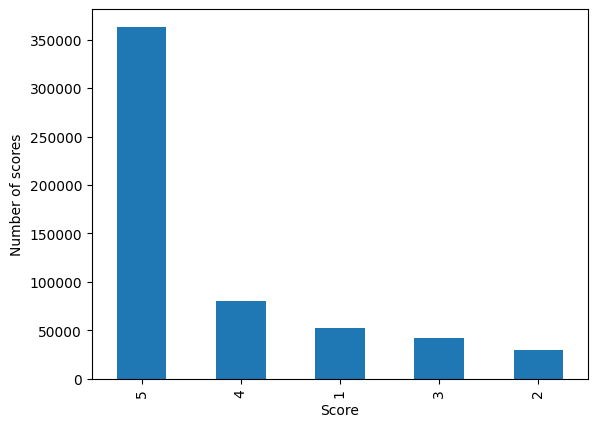

In [9]:
raw_df.Score.value_counts().plot(kind='bar')
plt.xlabel('Score');
plt.ylabel('Number of scores');

In [87]:
#Sorting data according to ProductId in ascending order
sort_data=raw_df.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [88]:
#Deduplication of entries
df=sort_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
df.shape

(393933, 10)

<Axes: >

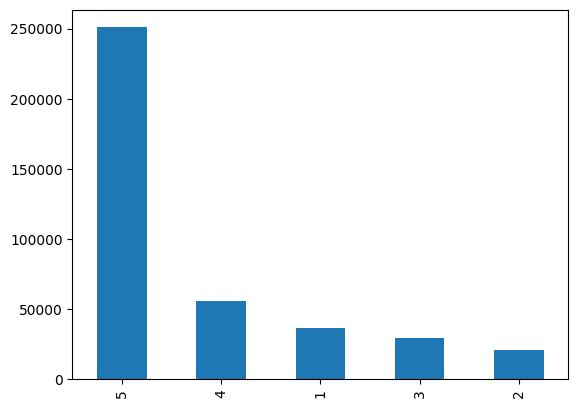

In [12]:
df['Score'].value_counts().plot(kind='bar') #after dropping duplicates

In [13]:
print("Average Score: ",np.mean(df.Score))
print("Median Score: ",np.median(df.Score))

Average Score:  4.179406142668931
Median Score:  5.0


In [89]:
import re

In [8]:

print((df.Text[0]))

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


In [9]:

review = TextBlob(df.Text[0])

In [10]:

review.words

WordList(['I', 'have', 'bought', 'several', 'of', 'the', 'Vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'The', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'My', 'Labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most'])

In [90]:
# Set of stopwords
stop_words = set(stopwords.words('english'))

# Initialize the  Lemmatizer
lemmatizer = WordNetLemmatizer()

def cleanpunc(sentence):
    # clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]', r' ', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    cleaned = re.sub(r'<br\s*/?>', '  ', cleaned)
    return cleaned

def preprocess_text(sentence):
    tokens = word_tokenize(sentence)
  
    tokens = [cleanpunc(token.lower()) for token in tokens if token.isalnum()]
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  
    cleaned_sentence = ' '.join(lemmatized_tokens)
    return cleaned_sentence

In [91]:
df['processed_text_lem'] = df['Text'].apply(preprocess_text)


In [92]:
print("Original text : ", df['Text'][1])
print("Processed text :", df['processed_text_lem'][1])

Original text :  Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
Processed text : product arrived labeled jumbo salted peanut peanut actually small sized unsalted sure error vendor intended represent product jumbo


In [93]:
df['rating_class'] = df['Score'].apply(lambda x: 'posi' if x >= 4 else ('neut' if x == 3 else 'nega'))

In [80]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,processed_text_lem,rating_class,Date_Time,sentiment_polarity,date,year,rating_class_encoded
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,june br saw charming group br rose begin br dr...,positive,2005-02-15,0.276136,2005-02-15,2005,3
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way child learn month year learn poem thro...,positive,2007-10-04,0.300000,2007-10-04,2007,3
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak book watching really rosie...,positive,2007-11-11,0.251389,2007-11-11,2007,3
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,4,1210809600,A classic,Get the movie or sound track and sing along wi...,get movie sound track sing along carol king gr...,positive,2008-05-15,0.466667,2008-05-15,2008,3
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,4,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertaining rhyming story cleaver illustratio...,positive,2008-06-01,0.255952,2008-06-01,2008,3


In [22]:
print("Proportion of reviews with high rates:", len(df[df.rating_class=="positive"])/len(df))
print("Proportion of reviews with medium rates:",len(df[df.rating_class=="neutral"])/len(df))
print("Proportion of reviews with low rates:",len(df[df.rating_class=="negative"])/len(df))

Proportion of reviews with high rates: 0.7794574204242853
Proportion of reviews with medium rates: 0.07557630358461973
Proportion of reviews with low rates: 0.14496627599109493


<Axes: >

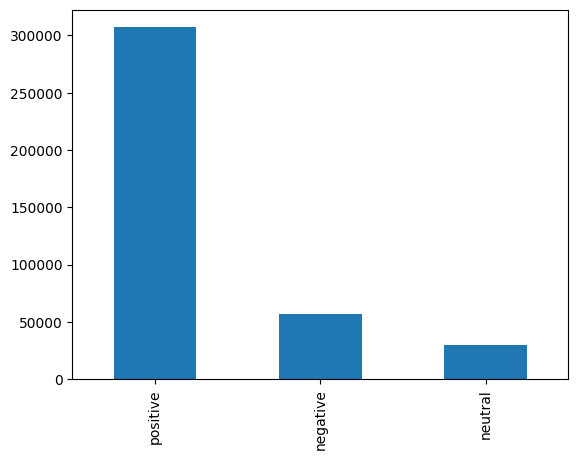

In [57]:
df['rating_class'].value_counts().plot(kind='bar')

In [94]:
df['Date_Time'] = pd.to_datetime(df['Time'], unit = 's')

In [95]:
from textblob import TextBlob

sentiment_scores = []

for text in df['processed_text_lem']:
   
    blob = TextBlob(text)

    # Perform sentiment analysis
    polarity = blob.sentiment.polarity
    
  
    sentiment_scores.append(polarity)


df['sentiment_polarity'] = sentiment_scores

print(df.head())


            Id   ProductId          UserId  \
150528  150529  0006641040   A25ACLV5KPB4W   
150506  150507  0006641040  A1S4A3IQ2MU7V4   
150505  150506  0006641040  A2IW4PEEKO2R0U   
150504  150505  0006641040  A2PTSM496CF40Z   
150503  150504  0006641040   AQEYF1AXARWJZ   

                                             ProfileName  \
150528                               Matt Hetling "Matt"   
150506                             sally sue "sally sue"   
150505                                             Tracy   
150504  Jason A. Teeple "Nobody made a greater mistak...   
150503                         Les Sinclair "book maven"   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
150528                     0                       1      4  1108425600   
150506                     1                       1      4  1191456000   
150505                     1                       1      4  1194739200   
150504                     1                       1      4  1

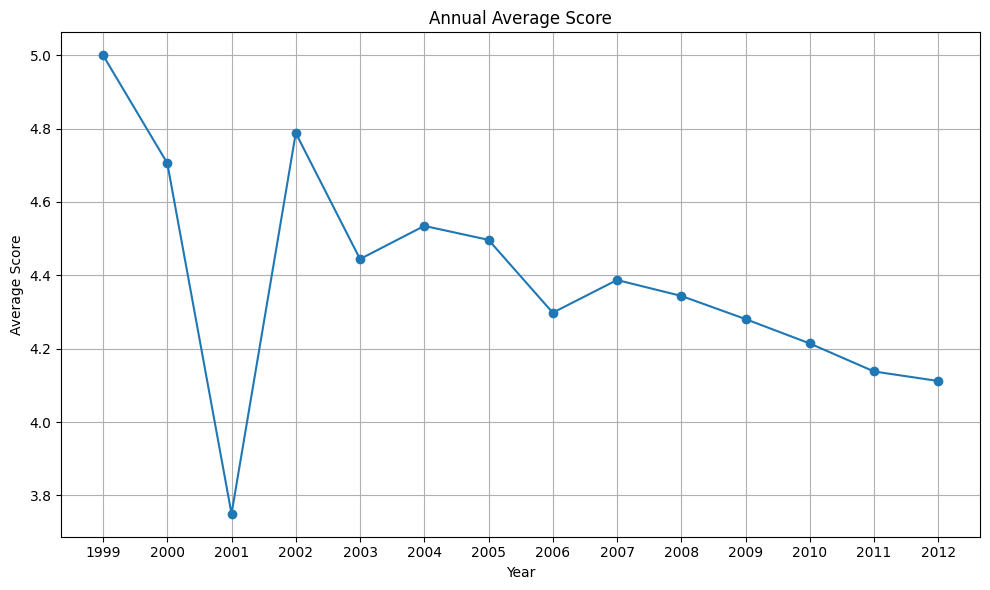

In [21]:

df['date'] = pd.to_datetime(df['Time'], unit='s')

df['year'] = df['Date_Time'].dt.year

annual_avg_score = df.groupby('year')['Score'].mean()

plt.figure(figsize=(10, 6))
plt.plot(annual_avg_score.index, annual_avg_score.values, marker='o', linestyle='-')

plt.xlabel('Year')
plt.ylabel('Average Score')
plt.title('Annual Average Score')


plt.grid(True)
plt.xticks(annual_avg_score.index)
plt.tight_layout()
plt.show()


In [96]:
!pip install imblearn

In [27]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [29]:
from imblearn.under_sampling import RandomUnderSampler

X = df[['processed_text_lem']]
y = df['rating_class']

undersample = RandomUnderSampler(sampling_strategy='auto')

X_under, y_under = undersample.fit_resample(X, y)

<Axes: >

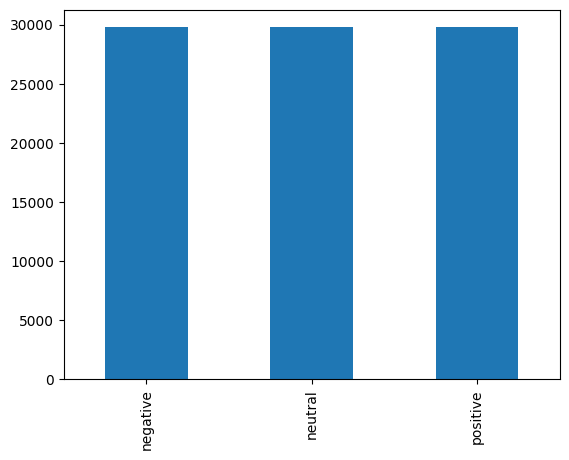

In [30]:
y_under.value_counts().plot(kind='bar')

In [97]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,processed_text_lem,rating_class,Date_Time,sentiment_polarity
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,june br saw charming group br rose begin br dr...,posi,2005-02-15,0.276136
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way child learn month year learn poem thro...,posi,2007-10-04,0.300000
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak book watching really rosie...,posi,2007-11-11,0.251389
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,4,1210809600,A classic,Get the movie or sound track and sing along wi...,get movie sound track sing along carol king gr...,posi,2008-05-15,0.466667
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,4,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertaining rhyming story cleaver illustratio...,posi,2008-06-01,0.255952


### Feature Extraction 


In [82]:
from sklearn.preprocessing import LabelEncoder

In [103]:
le = LabelEncoder()
df['rating_class_encoded'] = le.fit_transform(df['rating_class'])

In [104]:
df.head(40)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,processed_text_lem,rating_class,Date_Time,sentiment_polarity,rating_class_encoded
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,june br saw charming group br rose begin br dr...,posi,2005-02-15,0.276136,2
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way child learn month year learn poem thro...,posi,2007-10-04,0.300000,2
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak book watching really rosie...,posi,2007-11-11,0.251389,2
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,4,1210809600,A classic,Get the movie or sound track and sing along wi...,get movie sound track sing along carol king gr...,posi,2008-05-15,0.466667,2
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,4,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertaining rhyming story cleaver illustratio...,posi,2008-06-01,0.255952,2
150502,150503,0006641040,A3R5XMPFU8YZ4D,"Her Royal Motherliness ""Nana""",1,1,5,1233964800,so fun to read,This is my grand daughter's and my favorite bo...,grand daughter favorite book read 4 love rhyth...,posi,2009-02-07,0.480000,2
150501,150502,0006641040,AVFMJ50HNO21J,Jane Doe,1,1,4,1324944000,"Tiny little book, Wonderful little rhymes.",This copy is smaller than I expected (mostly b...,copy smaller expected mostly pay attention lis...,posi,2011-12-27,0.181250,2
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television year ago...,posi,1999-10-25,0.100000,2
150498,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,5,1065830400,Can't explain why,This book has been a favorite of mine since I ...,book favorite mine since able read one first i...,posi,2003-10-11,0.408333,2
150497,150498,0006641040,A3SJWISOCP31TR,R. J. Wells,2,2,5,1176336000,A Gem of a Book,This is a wonderful little book. I loved it 40...,wonderful little book loved 40 year ago twin l...,posi,2007-04-12,0.326562,2


In [105]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split


x = df['processed_text_lem']
y = df['rating_class']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=100)
print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (275753,)
shape of X_test is (118180,)
shape of y_train is (275753,)
shape of y_test is (118180,)


In [106]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer_BOW = CountVectorizer(lowercase=True)

X_train_bow = count_vectorizer_BOW.fit_transform(X_train)

X_test_bow = count_vectorizer_BOW.transform(X_test)

feature_names = count_vectorizer_BOW.get_feature_names_out()


print("Shape of X_train_bow:", X_train_bow.shape)
print("Shape of X_test_bow:", X_test_bow.shape)
print ("The number of unique words:", X_train_bow.get_shape()[1])
# Print some sample feature names
print("Sample feature names:", feature_names[:10])





Shape of X_train_bow: (275753, 84049)
Shape of X_test_bow: (118180, 84049)
The number of unique words: 84049
Sample feature names: ['00' '000' '0000soo' '0001' '001' '00100' '00127' '00128' '00129' '00130']


In [63]:
print(X_train_bow.shape)
print(y_train.shape)


(275753, 84005)
(275753,)


In [64]:
import sklearn; print(sklearn.__version__)

1.4.1.post1


In [65]:
#word frequency
word_counts = X_train_bow.sum(axis=0)

word_counts_array = np.asarray(word_counts).flatten()

word_frequency_dict = dict(zip(count_vectorizer_BOW.get_feature_names_out(), word_counts_array))

#  top N words by frequency
top_n_words = 20
sorted_word_frequency = sorted(word_frequency_dict.items(), key=lambda x: x[1], reverse=True)[:top_n_words]
print("Top", top_n_words, "words by frequency:")
for word, frequency in sorted_word_frequency:
    print(word, ":", frequency)


Top 20 words by frequency:
br : 311794
like : 124497
taste : 104766
good : 96207
product : 90109
one : 89606
flavor : 85266
great : 79582
love : 72988
tea : 72017
coffee : 71722
would : 64608
food : 57456
get : 56252
make : 54799
really : 48510
time : 47340
much : 44939
use : 43404
also : 41621


In [66]:
print(X_train_bow.shape)
print(y_train.shape)

(275753, 84005)
(275753,)


TF-IDF

In [107]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
tfidf_vectorizer = TfidfVectorizer()

x = df['processed_text_lem']
y = df['rating_class']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=100)
print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (275753,)
shape of X_test is (118180,)
shape of y_train is (275753,)
shape of y_test is (118180,)


In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer()


X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)


X_test_tfidf = tfidf_vectorizer.transform(X_test)


print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

Shape of X_train_tfidf: (275753, 84049)
Shape of X_test_tfidf: (118180, 84049)


In [109]:

features = tfidf_vectorizer.get_feature_names_out()
features

array(['00', '000', '0000soo', ...,
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 'çaykur', 'çelem'],
      dtype=object)

In [110]:
import numpy as np


avg_tfidf_scores = X_train_tfidf.mean(axis=0)


feature_names = tfidf_vectorizer.get_feature_names_out()

# average TF-IDF scores
word_tfidf_scores = dict(zip(feature_names, avg_tfidf_scores.A1))

# Sort the words based on their average TF-IDF scores
sorted_words = sorted(word_tfidf_scores.items(), key=lambda x: x[1], reverse=True)

# top 20 positive words and top 20 negative words
top_positive_words = sorted_words[:20]
top_negative_words = sorted_words[-20:]

print("Top 20 positive words based on TF-IDF scores:")
for word, score in top_positive_words:
    print(f"{word}: {score}")

print("\nTop 20 negative words based on TF-IDF scores:")
for word, score in top_negative_words:
    print(f"{word}: {score}")


Top 20 positive words based on TF-IDF scores:
br: 0.04786857561909039
like: 0.025947523432511905
taste: 0.02467867068810556
good: 0.024432659248238855
great: 0.02399572810671623
coffee: 0.02391484131636823
product: 0.023136265937246984
tea: 0.02285508795388191
love: 0.02243745448803112
flavor: 0.021725770452735074
one: 0.02004234255147237
would: 0.01611782562746526
food: 0.01481872326157391
get: 0.014753389502903403
make: 0.014384490021249419
really: 0.014182073483372332
price: 0.01399976903044591
time: 0.013418540077169165
dog: 0.013218469689961048
buy: 0.013052141596284969

Top 20 negative words based on TF-IDF scores:
intraepithelial: 7.768267694095495e-08
kyushu: 7.768267694095495e-08
laminin: 7.768267694095495e-08
maleskey: 7.768267694095495e-08
mammogram: 7.768267694095495e-08
mclarty: 7.768267694095495e-08
neoplasia: 7.768267694095495e-08
promiscuous: 7.768267694095495e-08
prostatectomy: 7.768267694095495e-08
slideshows: 7.768267694095495e-08
tamoxifen: 7.768267694095495e-08
vel

In [114]:
pip install -U gensim

WORD2VEC

In [47]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# Tokenize your text data
tokenized_text = [word_tokenize(text) for text in df['processed_text_lem']]

word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

vocabulary = word2vec_model.wv.key_to_index

sorted_vocabulary = sorted(vocabulary.items(), key=lambda item: word2vec_model.wv.get_vecattr(item[0], 'count'), reverse=True)


top_n_words = 10
for word, frequency in sorted_vocabulary[:top_n_words]:
    print(word, ":", word2vec_model.wv.get_vecattr(word, 'count'))


br : 446929
like : 178181
taste : 149791
good : 137953
product : 128923
one : 127747
flavor : 122325
great : 113632
love : 104788
tea : 102558


### BOW AND TF-IDF WITH DECISION TREES

Bag of Words

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer


X_train, X_test, y_train, y_test = train_test_split(X_train_bow, y_train, test_size=0.3, random_state=42)


classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

        nega       0.47      0.45      0.46     12052
        neut       0.18      0.14      0.15      6180
        posi       0.86      0.89      0.87     64494

    accuracy                           0.77     82726
   macro avg       0.50      0.49      0.50     82726
weighted avg       0.75      0.77      0.76     82726



TF-IDF

In [77]:

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y_train, test_size=0.3, random_state=42)

classifier = DecisionTreeClassifier()

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.43      0.44     12052
           1       0.17      0.14      0.16      6180
           2       0.86      0.88      0.87     64494

    accuracy                           0.76     82726
   macro avg       0.50      0.49      0.49     82726
weighted avg       0.75      0.76      0.75     82726



### TFIDF AND TSVD WITH NAIVE BAYES AND XGBOOST

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from gensim.models import FastText
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB

In [111]:
from sklearn.preprocessing import LabelEncoder
# Apply TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['processed_text_lem'])

# Apply TSVD
tsvd = TruncatedSVD(n_components=100)
X_tsvd = tsvd.fit_transform(X_tfidf)

# Encode the target variable
#le = LabelEncoder()
#df['rating_class_encoded'] = le.fit_transform(df['rating_class'])

# Print the classes and their corresponding encoded values
for class_, label in zip(le.classes_, range(len(le.classes_))):
    print(f"'{class_}' is encoded as {label}")

# Split the data
X_train_tsvd, X_test_tsvd, y_train_tsvd, y_test_tsvd = train_test_split(X_tsvd, df['rating_class_encoded'], test_size=0.2, random_state=42)

# Train Gaussian Naive Bayes
gnb_tsvd = GaussianNB()
gnb_tsvd.fit(X_train_tsvd, y_train_tsvd)
y_pred_tsvd = gnb_tsvd.predict(X_test_tsvd)

# Train Bernoulli Naive Bayes
bnb_tsvd = BernoulliNB()
bnb_tsvd.fit(X_train_tsvd, y_train_tsvd)
y_pred_tsvd = bnb_tsvd.predict(X_test_tsvd)
print(classification_report(y_test_tsvd, y_pred_tsvd))

# Train XGBoost
xgb_tsvd = XGBClassifier()
xgb_tsvd.fit(X_train_tsvd, y_train_tsvd)
y_pred_tsvd = xgb_tsvd.predict(X_test_tsvd)
print(classification_report(y_test_tsvd, y_pred_tsvd))

'nega' is encoded as 0
'neut' is encoded as 1
'posi' is encoded as 2
              precision    recall  f1-score   support

           0       0.55      0.26      0.36     11482
           1       0.29      0.02      0.04      5909
           2       0.82      0.97      0.89     61396

    accuracy                           0.79     78787
   macro avg       0.55      0.42      0.43     78787
weighted avg       0.74      0.79      0.74     78787

              precision    recall  f1-score   support

           0       0.63      0.43      0.51     11482
           1       0.34      0.03      0.05      5909
           2       0.84      0.97      0.90     61396

    accuracy                           0.82     78787
   macro avg       0.60      0.47      0.49     78787
weighted avg       0.77      0.82      0.78     78787



### FastText with Naive Bayes and Xgboost

In [116]:
import numpy as np

# Apply FastText
sentences = df['processed_text_lem'].apply(lambda row: row.split())
ft_model = FastText(sentences, vector_size=100, window=5, min_count=5, workers=4)

# Get the vectors for each word in the sentence and take the mean
X_ft = df['processed_text_lem'].apply(lambda row: np.array([ft_model.wv[word] for word in row.split()]).mean(axis=0))

# Convert list of arrays to 2D array
X_ft = np.vstack(X_ft)

# Encode the target variable
#le = LabelEncoder()
#df['rating_class_encoded'] = le.fit_transform(df['rating_class'])

# Print the classes and their corresponding encoded values
for class_, label in zip(le.classes_, range(len(le.classes_))):
    print(f"'{class_}' is encoded as {label}")

# Split the data and train the models
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X_ft, df['rating_class_encoded'], test_size=0.2, random_state=42)

# Train Gaussian Naive Bayes
#gnb_ft = GaussianNB()
#gnb_ft.fit(X_train_tf, y_train_ft)
#y_pred_ft = gnb_tf.predict(X_test_ft)
#print(classification_report(y_test_ft, y_pred_ft))

# Train XGBoost
xgb_ft = XGBClassifier()
xgb_ft.fit(X_train_ft, y_train_ft)
y_pred_ft = xgb_ft.predict(X_test_ft)
print(classification_report(y_test_ft, y_pred_ft))

'nega' is encoded as 0
'neut' is encoded as 1
'posi' is encoded as 2
              precision    recall  f1-score   support

           0       0.68      0.53      0.59     11482
           1       0.39      0.05      0.09      5909
           2       0.86      0.97      0.91     61396

    accuracy                           0.83     78787
   macro avg       0.64      0.52      0.53     78787
weighted avg       0.80      0.83      0.80     78787



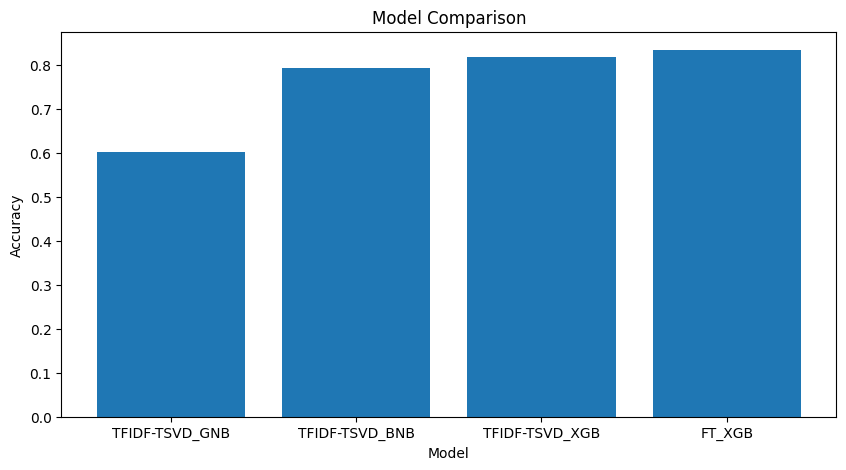

In [119]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate accuracy of each model
accuracy_tsvd_gnb = gnb_tsvd.score(X_test_tsvd, y_test_tsvd)
accuracy_tsvd_bnb = bnb_tsvd.score(X_test_tsvd, y_test_tsvd)
accuracy_tsvd_xgb = xgb_tsvd.score(X_test_tsvd, y_test_tsvd)
#accuracy_ft_gnb = gnb_ft.score(X_test_ft, y_test_ft)
accuracy_ft_xgb = xgb_ft.score(X_test_ft, y_test_ft)

# Store in a dictionary
results = {'TFIDF-TSVD_GNB': accuracy_tsvd_gnb, 'TFIDF-TSVD_BNB': accuracy_tsvd_bnb, 'TFIDF-TSVD_XGB': accuracy_tsvd_xgb,  'FT_XGB': accuracy_ft_xgb}

# Convert to DataFrame for easier plotting
df_results = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])

# Plot
plt.figure(figsize=(10, 5))
plt.bar(df_results['Model'], df_results['Accuracy'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()


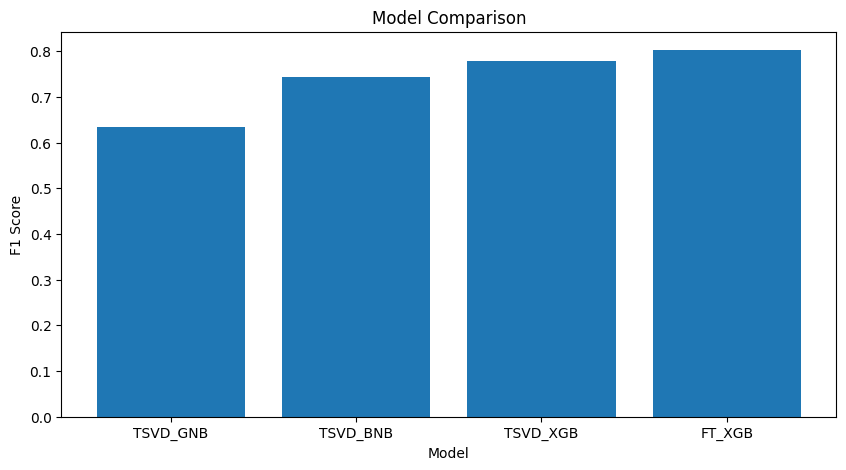

In [120]:
from sklearn.metrics import f1_score

# Calculate F1 scores of each model
y_pred_tsvd_gnb = gnb_tsvd.predict(X_test_tsvd)
f1_tsvd_gnb = f1_score(y_test_tsvd, y_pred_tsvd_gnb, average='weighted')

y_pred_tsvd_bnb = bnb_tsvd.predict(X_test_tsvd)
f1_tsvd_bnb = f1_score(y_test_tsvd, y_pred_tsvd_bnb, average='weighted')

y_pred_tsvd_xgb = xgb_tsvd.predict(X_test_tsvd)
f1_tsvd_xgb = f1_score(y_test_tsvd, y_pred_tsvd_xgb, average='weighted')

#y_pred_ft_gnb = gnb_ft.predict(X_test_ft)
#f1_ft_gnb = f1_score(y_test_ft, y_pred_ft_gnb, average='weighted')

y_pred_ft_xgb = xgb_ft.predict(X_test_ft)
f1_ft_xgb = f1_score(y_test_ft, y_pred_ft_xgb, average='weighted')

# Store in a dictionary
results = {'TSVD_GNB': f1_tsvd_gnb, 'TSVD_BNB': f1_tsvd_bnb, 'TSVD_XGB': f1_tsvd_xgb,  'FT_XGB': f1_ft_xgb}

# Convert to DataFrame for easier plotting
df_results = pd.DataFrame(list(results.items()), columns=['Model', 'F1 Score'])

# Plot
plt.figure(figsize=(10, 5))
plt.bar(df_results['Model'], df_results['F1 Score'])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Model Comparison')
plt.show()

# Sentiment Analysis with VADER (Valence Aware Dictionary and Sentiment Reasoner) - Bag of words approach

In [ ]:
!pip install seaborn

In [ ]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['processed_text_lem']
    myid = i  # using index as unique identifier
    res[myid] = sia.polarity_scores(text)


In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# AZURE ML


In [19]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

# authenticate
credential = DefaultAzureCredential()
# # Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="adc7a4a1-5e08-4820-8f47-0bdd50167901",
    resource_group_name="AIEngineerAcademy",
    workspace_name="CapstoneProject",
)

In [ ]:
!az account show

{
  "environmentName": "AzureCloud",
  "homeTenantId": "cf36141c-ddd7-45a7-b073-111f66d0b30c",
  "id": "adc7a4a1-5e08-4820-8f47-0bdd50167901",
  "isDefault": true,
  "managedByTenants": [],

    "cloudName": "AzureCloud",


  "id": "adc7a4a1-5e08-4820-8f47-0bdd50167901",
  "isDefault": true,
  "managedByTenants": [],
  "name": "Visual Studio Professional Subscription",
  "state": "Enabled",
  "tenantId": "cf36141c-ddd7-45a7-b073-111f66d0b30c",
  "user": {
    "name": "tara.kennedy@avanade.com",
    "type": "user"
  }
}


In [102]:
!az login

[


  {

In [ ]:
!az upgrade

In [20]:
import os

dependencies_dir = "./dependencies"
os.makedirs(dependencies_dir, exist_ok=True)

In [74]:
%%writefile {dependencies_dir}/conda.yml
name: capstone_env
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.8
  - asttokens
  - backcall
  - colorama
  - comm
  - debugpy
  - decorator
  - executing
  - importlib-metadata
  - ipykernel
  - ipython
  - jedi
  - jupyter_client
  - jupyter_core
  - matplotlib-inline
  - nest-asyncio
  - packaging
  - parso
  - pickleshare
  - prompt-toolkit
  - psutil
  - pure_eval
  - pygments
  - python-dateutil
  - six
  - stack_data
  - tornado
  - traitlets
  - typing_extensions
  - wcwidth
  - zipp
  - pip:
    - click
    - contourpy
    - cycler
    - fonttools
    - gensim
    - imbalanced-learn
    - importlib-resources
    - ipywidgets
    - joblib
    - jupyterlab-widgets
    - kiwisolver
    - nltk
    - numpy
    - pandas
    - pillow
    - pyparsing
    - pytz
    - regex
    - scikit-learn
    - scipy
    - seaborn
    - smart-open
    - textblob
    - threadpoolctl
    - tqdm
    - tzdata
    - widgetsnbextension
    - wrapt
    - xgboost

Overwriting ./dependencies/conda.yml


In [12]:
from azure.ai.ml.entities import Environment

custom_env_name = "NewEnvironment"

custom_job_env = Environment(
    name=custom_env_name,
    description="Custom environment for Capstone Project",
    tags={"scikit-learn": "0.24.2"},
    conda_file=os.path.join(dependencies_dir, "conda.yml"),
    image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest",
)
custom_job_env = ml_client.environments.create_or_update(custom_job_env)

print(
    f"Environment with name {custom_job_env.name} is registered to workspace, the environment version is {custom_job_env.version}"
)

Environment with name NewEnvironment is registered to workspace, the environment version is 1


In [13]:
import os

train_src_dir = "./Resources/src"
os.makedirs(train_src_dir, exist_ok=True)

In [14]:
%%writefile {train_src_dir}/main.py
import os
import argparse
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split





def main():
    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument("--registered_model_name", type=str, help="model name")
    args = parser.parse_args()
   
    # Start Logging
    mlflow.start_run()

    # enable autologging
    mlflow.sklearn.autolog()

    ###################
    #<prepare the data>
    ###################
    print(" ".join(f"{k}={v}" for k, v in vars(args).items()))

    print("input data:", args.data)
    
    data = pd.read_csv(args.data, header=1, index_col=0)

    mlflow.log_metric("num_samples", data.shape[0])
    mlflow.log_metric("num_features", data.shape[1] - 1)

    df = data.drop_duplicates(subset=['UserId','ProfileName','Time','Text'],keep='first',inplace=False)
    df.shape

    df['rating_class'] = df['Score'].apply(lambda x: 'posi' if x >= 4 else ('neut' if x == 3 else 'nega'))
    
    
    from nltk.stem import PorterStemmer
    nltk.download('stopwords')
    import re

    # Converting uppercase into lowercase
    df['Text_processed'] = df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Removing punctuation marks, extra spaces, and numbers
    df['Text_processed'] = df['Text_processed'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    df['Text_processed'] = df['Text_processed'].apply(lambda x: re.sub(r'\s+', ' ', x))
    df['Text_processed'] = df['Text_processed'].apply(lambda x: re.sub(r'\d+', '', x))

   # Removing stopwords
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    stop += ['.', '/', '<', '>', '``', '"', '-', '--']
    df['Text_processed'] = df['Text_processed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

   # Create a new Porter stemmer.
    stemmer = PorterStemmer()
    
    df['Text_processed'] = df['Text_processed'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))


   # Performing lemmatization
   # from textblob import Word
   # df['Text_processed'] = df['Text_processed'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
   
   
    from imblearn.under_sampling import RandomUnderSampler
    
    X = df[['Text_processed']]
    y = df['rating_class']
    
    undersample = RandomUnderSampler(sampling_strategy='auto')
    
    X_under, y_under = undersample.fit_resample(X, y)
    
    df_under = pd.concat([X_under, y_under], axis=1)


    ####################
    #</prepare the data>
    ####################

    ##################
    #<train the model>
    ##################
    #Apply FastText
    sentences = df_under['Text_processed'].apply(lambda row: row.split())
    ft_model = FastText(sentences, vector_size=100, window=5, min_count=5, workers=4)

    # Get the vectors for each word in the sentence and take the mean
    X_ft = df_under['Text_processed'].apply(lambda row: np.array([ft_model.wv[word] for word in row.split()]).mean(axis=0))

    # Convert list of arrays to 2D array
    X_ft = np.vstack(X_ft)

    # Encode the target variable
    le = LabelEncoder()
    df_under['rating_class_encoded'] = le.fit_transform(df_under['rating_class'])

    # Print the classes and their corresponding encoded values
    for class_, label in zip(le.classes_, range(len(le.classes_))):
        print(f"'{class_}' is encoded as {label}")

    # Split the data and train the models
    X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X_ft, df_under['rating_class_encoded'], test_size=0.2, random_state=42)

    # Train XGBoost
    xgb_ft = XGBClassifier()
    xgb_ft.fit(X_train_ft, y_train_ft)
    y_pred_ft = xgb_ft.predict(X_test_ft)
    print(classification_report(y_test_ft, y_pred_ft))

  

    ###################
    #</train the model>
    ##################

    ##########################
    #<save and register model>
    ##########################
    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=xgb_ft,
        registered_model_name=args.registered_model_name,
        artifact_path=args.registered_model_name,
    )

    # Saving the model to a file
    mlflow.sklearn.save_model(
        sk_model=xgb_ft,
        path=os.path.join(args.registered_model_name, "trained_model"),
    )
    ###########################
    #</save and register model>
    ###########################
    
    # Stop Logging
    mlflow.end_run()

if __name__ == "__main__":
    main()

Overwriting ./Resources/src/main.py


In [27]:
from azure.ai.ml import command
from azure.ai.ml import Input

registered_model_name = "Capstone Project"

job = command(
    inputs=dict(
        data=Input(
            type="uri_file",
            path="https://capstoneprojec6070375151.blob.core.windows.net/azureml-blobstore-1d294a27-cc65-456f-b5d1-cddb6172f5db/UI/2024-03-06_163934_UTC/amazon_fine_food_reviews.csv",
        ), 
        registered_model_name=registered_model_name,
    ),
    code="./Resources/src/",  # location of source code
    command="python main.py --data ${{inputs.data}} --registered_model_name ${{inputs.registered_model_name}}",
    environment="NewEnvironment:1",
    compute="Capstone-compute-cluster",
    display_name="Capstone Project",
)

In [28]:
ml_client.create_or_update(job)

Experiment,Name,Type,Status,Details Page
Capstone,honest_deer_6t8bp6592f,command,Starting,Link to Azure Machine Learning studio


# not relevant

In [77]:
import os

data_prep_src_dir = "./components/data_prep"
os.makedirs(data_prep_src_dir, exist_ok=True)

In [80]:
%%writefile {data_prep_src_dir}/data_prep.py
import os
import argparse
import pandas as pd
from sklearn.model_selection import train_test_split
import logging
import mlflow
import nltk


def main():
    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument("--output_data", type=str, help="path to train data")
   
    args = parser.parse_args()

    # Start Logging
    mlflow.start_run()

    print(" ".join(f"{k}={v}" for k, v in vars(args).items()))

    print("input data:", args.data)

    #if os.path.a

    
    data = pd.read_csv(args.data, header=1, index_col=0)

    mlflow.log_metric("num_samples", data.shape[0])
    mlflow.log_metric("num_features", data.shape[1] - 1)
     
    df = data.drop_duplicates(subset=['UserId','ProfileName','Time','Text'],keep='first',inplace=False)
    df.shape

    df['rating_class'] = df['Score'].apply(lambda x: 'posi' if x >= 4 else ('neut' if x == 3 else 'nega'))
    
    
    from nltk.stem import PorterStemmer
    nltk.download('stopwords')
    import re

    # Converting uppercase into lowercase
    df['Text_processed'] = df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Removing punctuation marks, extra spaces, and numbers
    df['Text_processed'] = df['Text_processed'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    df['Text_processed'] = df['Text_processed'].apply(lambda x: re.sub(r'\s+', ' ', x))
    df['Text_processed'] = df['Text_processed'].apply(lambda x: re.sub(r'\d+', '', x))

   # Removing stopwords
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    stop += ['.', '/', '<', '>', '``', '"', '-', '--']
    df['Text_processed'] = df['Text_processed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

   # Create a new Porter stemmer.
    stemmer = PorterStemmer()
    
    df['Text_processed'] = df['Text_processed'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))


   # Performing lemmatization
   # from textblob import Word
   # df['Text_processed'] = df['Text_processed'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
   
   
    from imblearn.under_sampling import RandomUnderSampler
    
    X = df[['Text_processed']]
    y = df['rating_class']
    
    undersample = RandomUnderSampler(sampling_strategy='auto')
    
    X_under, y_under = undersample.fit_resample(X, y)
    
    df_under = pd.concat([X_under, y_under], axis=1)

    df_under.to_csv(os.path.join(args.output_data, "data.csv"), index=False)

    # Stop Logging
    mlflow.end_run()


if __name__ == "__main__":
    main()

Overwriting ./components/data_prep/data_prep.py


In [104]:
# importing the Component Package
from azure.ai.ml import load_component

# Loading the component from the yml file
train_component = load_component(source=os.path.join(train_src_dir, "train.yml"))

# Now we register the component to the workspace
train_component = ml_client.create_or_update(train_component)

# Create (register) the component in your workspace
print(
    f"Component {train_component.name} with Version {train_component.version} is registered"
)

AzureCliCredential.get_token failed: Failed to invoke the Azure CLI


CredentialUnavailableError: Failed to invoke the Azure CLI